In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error)
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)
df = pd.read_csv('/content/drive/MyDrive/C++_project/ML/weekly_expenses.csv')

In [6]:
# Create time-based features
df['YearWeek'] = df['Year'].astype(str) + '-W' + df['Week'].astype(str).str.zfill(2)
df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [7]:
# Create seasonal indicators
df['Is_Spring'] = df['Month'].isin([3, 4, 5]).astype(int)
df['Is_Summer'] = df['Month'].isin([6, 7, 8]).astype(int)
df['Is_Fall'] = df['Month'].isin([9, 10, 11]).astype(int)
df['Is_Winter'] = df['Month'].isin([12, 1, 2]).astype(int)

In [8]:
# Create livestock season indicators
df['Is_Breeding_Season'] = df['Month'].isin([11, 12, 1, 2]).astype(int)
df['Is_Calving_Season'] = df['Month'].isin([2, 3, 4]).astype(int)
df['Is_Growing_Season'] = df['Month'].isin([4, 5, 6, 7, 8]).astype(int)
df['Is_Harvest_Season'] = df['Month'].isin([9, 10, 11]).astype(int)

In [9]:
# Create lag features (previous weeks' expenses)
for lag in [1, 2, 3, 4]:
    df[f'Total_Expenses_Lag_{lag}'] = df['Total_Weekly_Expenses'].shift(lag)

In [10]:
# Create rolling average features
for window in [4, 8, 12]:  # 4-week, 8-week, 12-week rolling averages
    df[f'Total_Expenses_MA_{window}'] = df['Total_Weekly_Expenses'].rolling(window=window).mean()

In [11]:
# Create year-over-year comparison
df['Total_Expenses_YoY'] = df['Total_Weekly_Expenses'].pct_change(periods=52)

In [13]:
# Drop rows with NaN values created by lag features
df_clean = df.dropna()
print(f"Dataset after cleaning: {df_clean.shape}")

Dataset after cleaning: (261, 50)


In [14]:
target = 'Total_Weekly_Expenses'

exclude_cols = ['Year', 'Week', 'Month', 'YearWeek', target]

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
print(f" Using {len(feature_cols)} features for training")

 Using 45 features for training


In [15]:
X = df_clean[feature_cols]
y = df_clean[target]

print(f"\nFeature set shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(f"  Mean: ${y.mean():,.2f}")
print(f"  Median: ${y.median():,.2f}")
print(f"  Std: ${y.std():,.2f}")
print(f"  Min: ${y.min():,.2f}")
print(f"  Max: ${y.max():,.2f}")


Feature set shape: (261, 45)
Target shape: (261,)

Target statistics:
  Mean: $308,970.42
  Median: $284,396.45
  Std: $95,318.00
  Min: $173,615.11
  Max: $562,382.74


In [16]:
# Use time-based split: last 20% for testing
split_idx = int(len(df_clean) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set: {X_train.shape[0]} weeks")
print(f"Test set: {X_test.shape[0]} weeks")
print(f"Split ratio: {X_train.shape[0]/len(X):.1%} train / {X_test.shape[0]/len(X):.1%} test")

Training set: 208 weeks
Test set: 53 weeks
Split ratio: 79.7% train / 20.3% test


In [17]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
models = {
    #'Linear Regression': LinearRegression(),
    #'Ridge Regression': Ridge(alpha=1.0),
    #'Lasso Regression': Lasso(alpha=1.0),
    #'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    #'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, verbose=-1),
    'AdaBoost': AdaBoostRegressor(n_estimators=50, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor': SVR(kernel='rbf', C=100, epsilon=0.1)
}

# Store results
results = []
trained_models = {}

In [23]:
for name, model in models.items():
    print(f"\n  Training {name}", end=" ")

    try:
        # Decide whether to use scaled or unscaled data
        if name in ['K-Nearest Neighbors', 'Support Vector Regressor']:
            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

        # Calculate metrics
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
        test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train MAPE': train_mape,
            'Test MAPE': test_mape
        })

        trained_models[name] = model
        print(f"(Test R²: {test_r2:.4f}, Test MAPE: {test_mape:.2f}%)")

    except Exception as e:
        print(f"Failed: {str(e)}")


  Training Random Forest (Test R²: 0.9288, Test MAPE: 5.34%)

  Training Extra Trees (Test R²: 0.9435, Test MAPE: 5.22%)

  Training Gradient Boosting (Test R²: 0.8795, Test MAPE: 6.08%)

  Training XGBoost (Test R²: 0.7857, Test MAPE: 7.29%)

  Training LightGBM Failed: Do not support special JSON characters in feature name.

  Training AdaBoost (Test R²: 0.8860, Test MAPE: 7.42%)

  Training K-Nearest Neighbors (Test R²: 0.9505, Test MAPE: 5.18%)

  Training Support Vector Regressor (Test R²: -0.6609, Test MAPE: 20.91%)


In [24]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R²', ascending=False)

In [25]:
# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
print(f"\nBEST MODEL: {best_model_name}")
print(f"Test R² Score: {results_df.iloc[0]['Test R²']:.4f}")
print(f"Test RMSE: ${results_df.iloc[0]['Test RMSE']:,.2f}")
print(f"Test MAPE: {results_df.iloc[0]['Test MAPE']:.2f}%")


BEST MODEL: K-Nearest Neighbors
Test R² Score: 0.9505
Test RMSE: $21,312.43
Test MAPE: 5.18%


In [26]:
import os
os.makedirs('/content/drive/MyDrive/C++_project/ML', exist_ok=True)

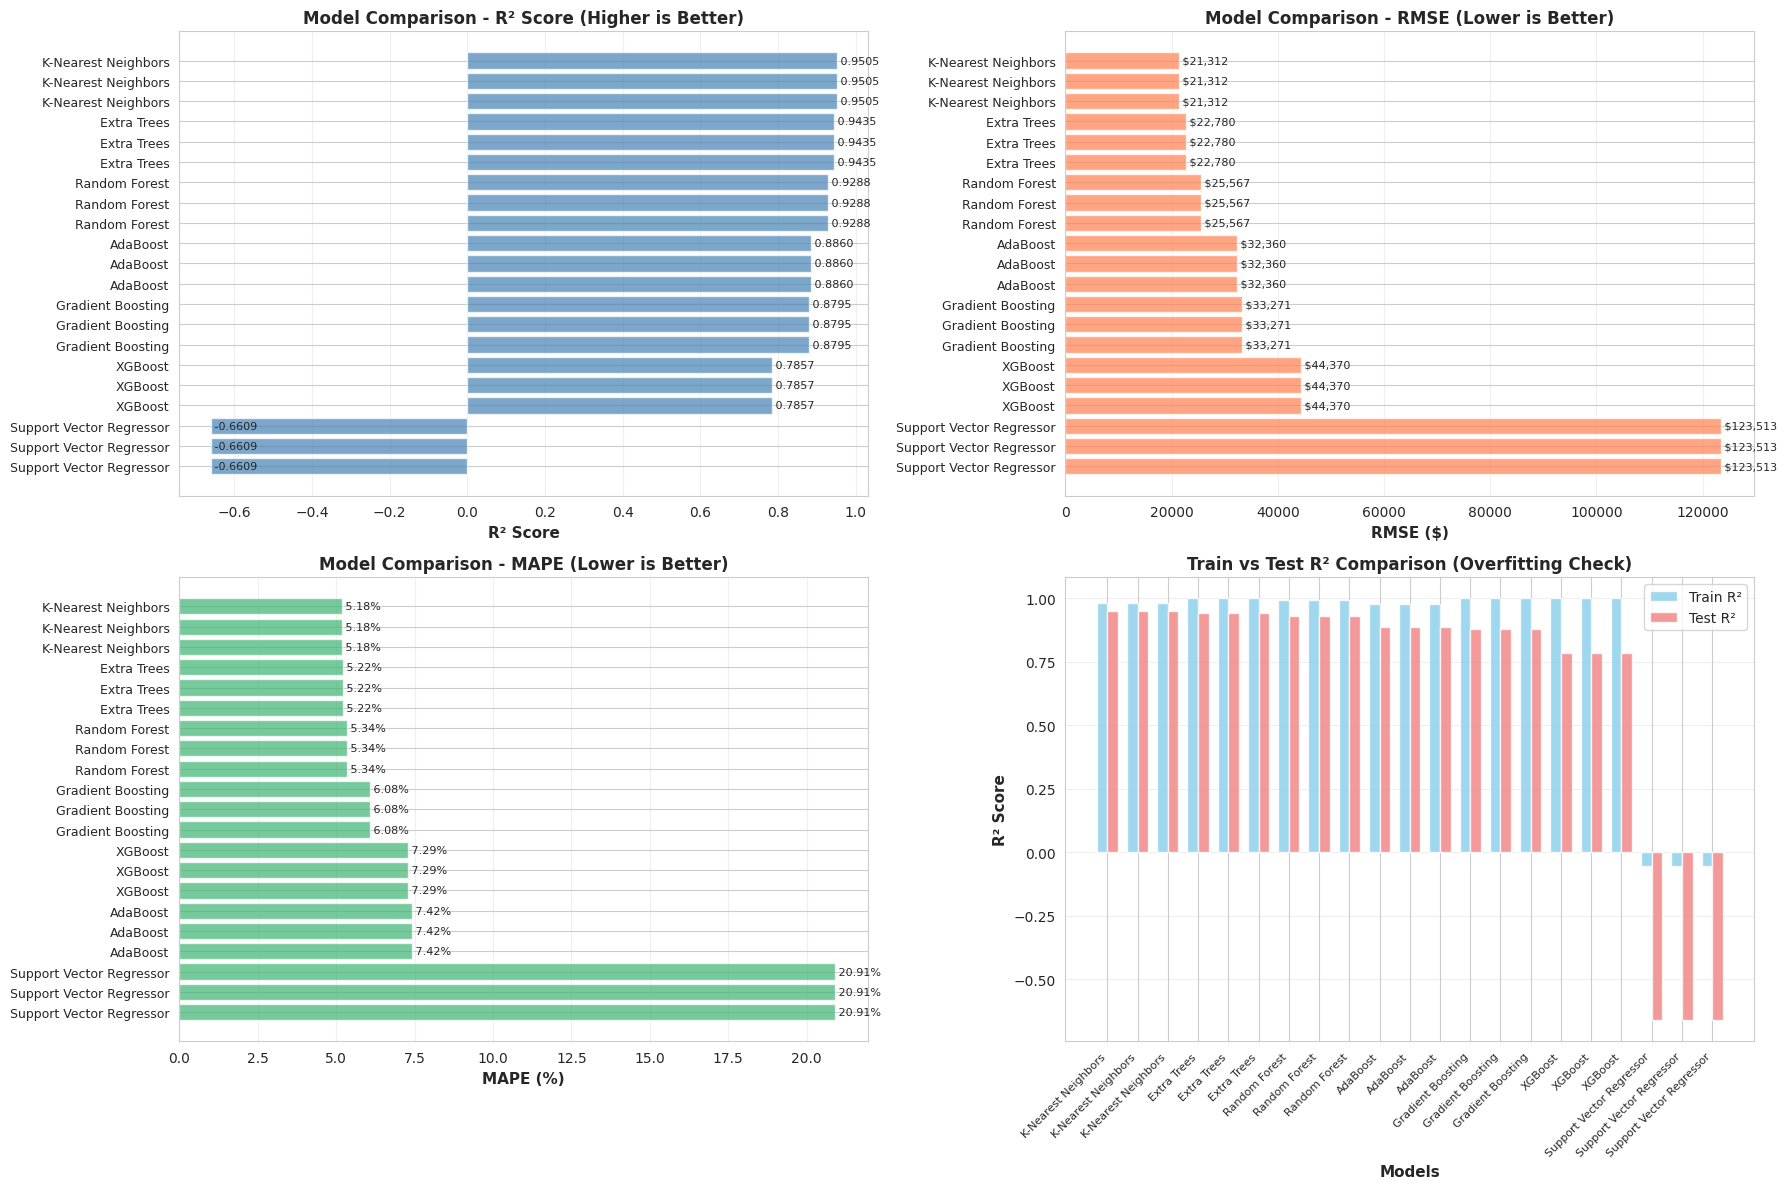

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
# R² Score comparison
ax1 = axes[0, 0]
models_sorted = results_df.sort_values('Test R²', ascending=True)
y_pos = np.arange(len(models_sorted))
ax1.barh(y_pos, models_sorted['Test R²'], color='steelblue', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models_sorted['Model'], fontsize=9)
ax1.set_xlabel('R² Score', fontsize=11, fontweight='bold')
ax1.set_title('Model Comparison - R² Score (Higher is Better)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(models_sorted['Test R²']):
    ax1.text(v, i, f' {v:.4f}', va='center', fontsize=8)

# RMSE comparison
ax2 = axes[0, 1]
models_sorted_rmse = results_df.sort_values('Test RMSE', ascending=False)
y_pos = np.arange(len(models_sorted_rmse))
ax2.barh(y_pos, models_sorted_rmse['Test RMSE'], color='coral', alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(models_sorted_rmse['Model'], fontsize=9)
ax2.set_xlabel('RMSE ($)', fontsize=11, fontweight='bold')
ax2.set_title('Model Comparison - RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(models_sorted_rmse['Test RMSE']):
    ax2.text(v, i, f' ${v:,.0f}', va='center', fontsize=8)

# MAPE comparison
ax3 = axes[1, 0]
models_sorted_mape = results_df.sort_values('Test MAPE', ascending=False)
y_pos = np.arange(len(models_sorted_mape))
ax3.barh(y_pos, models_sorted_mape['Test MAPE'], color='mediumseagreen', alpha=0.7)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(models_sorted_mape['Model'], fontsize=9)
ax3.set_xlabel('MAPE (%)', fontsize=11, fontweight='bold')
ax3.set_title('Model Comparison - MAPE (Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(models_sorted_mape['Test MAPE']):
    ax3.text(v, i, f' {v:.2f}%', va='center', fontsize=8)

# Train vs Test R² comparison
ax4 = axes[1, 1]
x = np.arange(len(results_df))
width = 0.35
ax4.bar(x - width/2, results_df['Train R²'], width, label='Train R²', color='skyblue', alpha=0.8)
ax4.bar(x + width/2, results_df['Test R²'], width, label='Test R²', color='lightcoral', alpha=0.8)
ax4.set_xlabel('Models', fontsize=11, fontweight='bold')
ax4.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax4.set_title('Train vs Test R² Comparison (Overfitting Check)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=8)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()

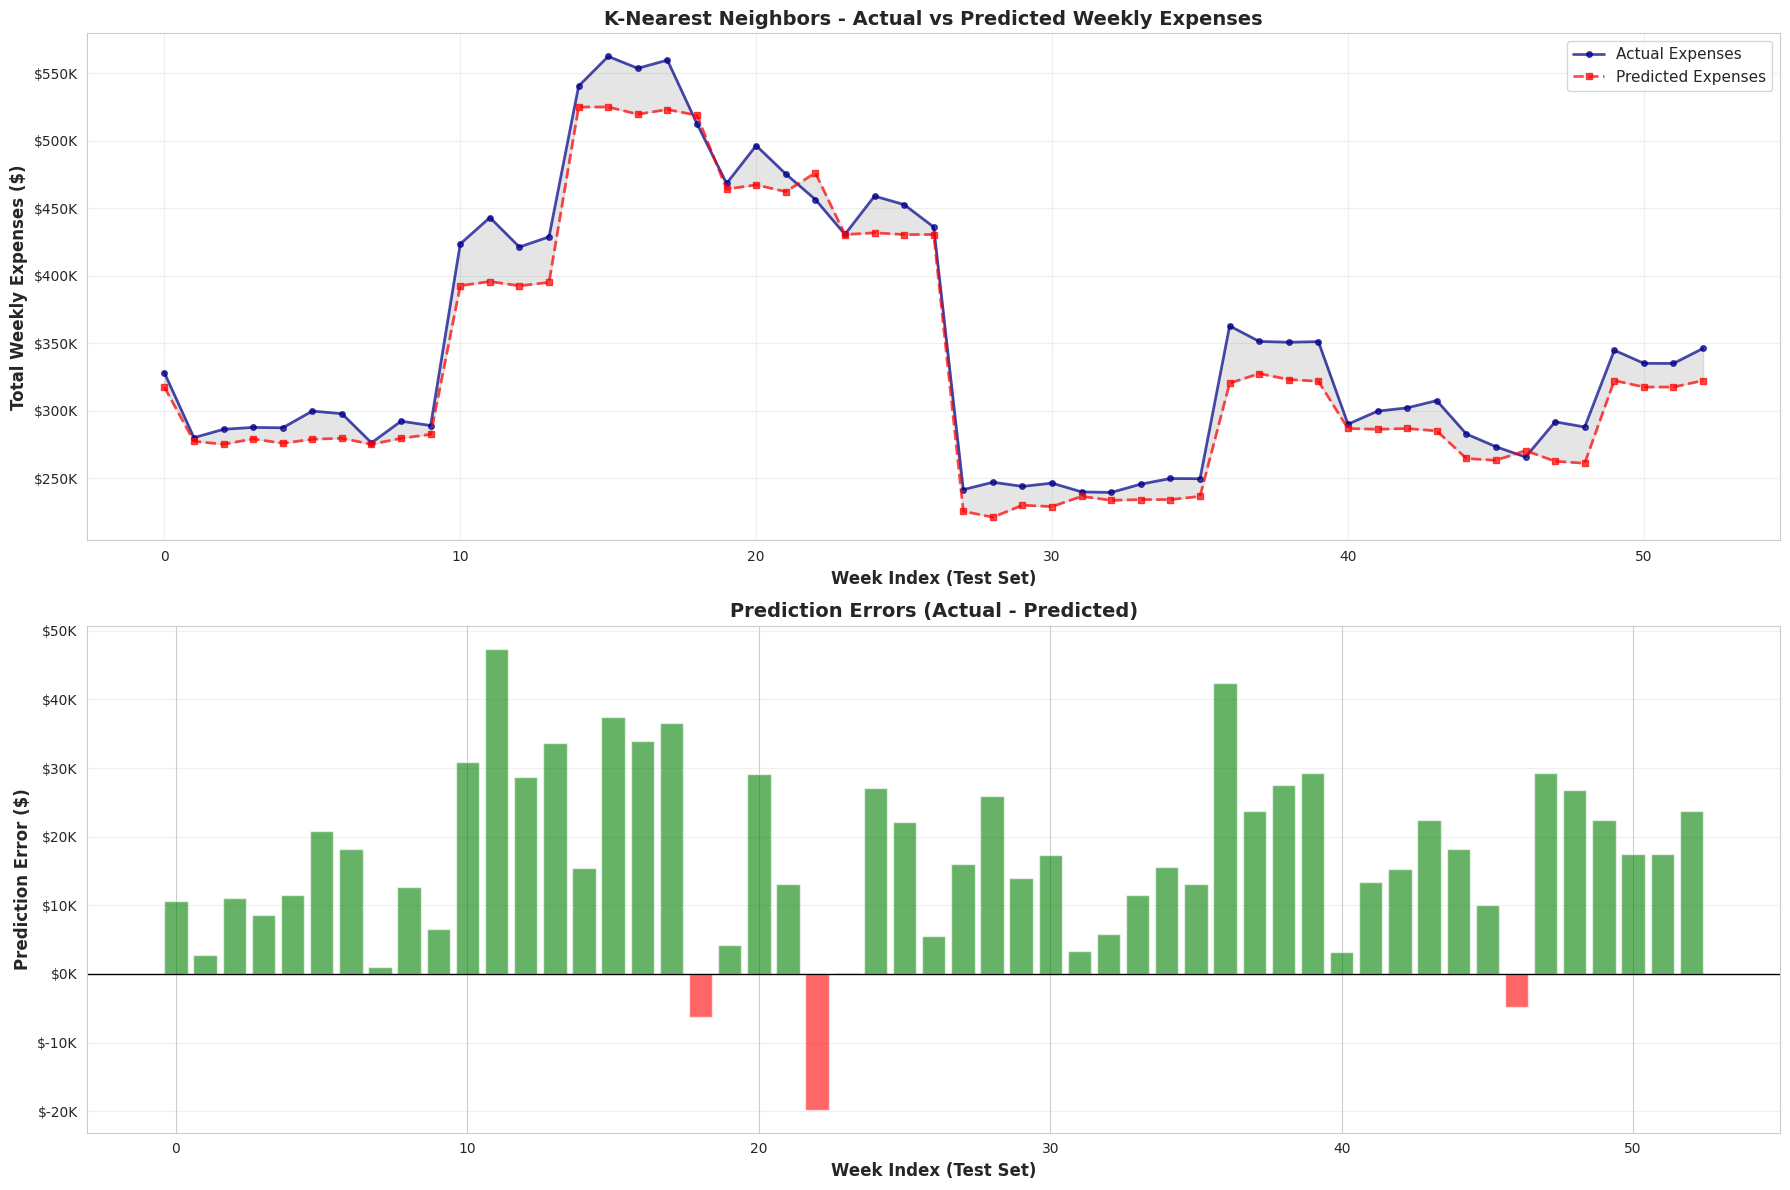

In [29]:
# Best model predictions plot
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Get best model predictions
if best_model_name in ['K-Nearest Neighbors', 'Support Vector Regressor']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Actual vs Predicted over time
ax1 = axes[0]
test_weeks = np.arange(len(y_test))
ax1.plot(test_weeks, y_test.values, label='Actual Expenses', marker='o', markersize=4,
         linewidth=2, color='darkblue', alpha=0.7)
ax1.plot(test_weeks, y_pred_best, label='Predicted Expenses', marker='s', markersize=4,
         linewidth=2, color='red', alpha=0.7, linestyle='--')
ax1.fill_between(test_weeks, y_test.values, y_pred_best, alpha=0.2, color='gray')
ax1.set_xlabel('Week Index (Test Set)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Weekly Expenses ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'{best_model_name} - Actual vs Predicted Weekly Expenses',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Prediction errors
ax2 = axes[1]
errors = y_test.values - y_pred_best
ax2.bar(test_weeks, errors, color=['green' if e > 0 else 'red' for e in errors], alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Week Index (Test Set)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prediction Error ($)', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Errors (Actual - Predicted)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()

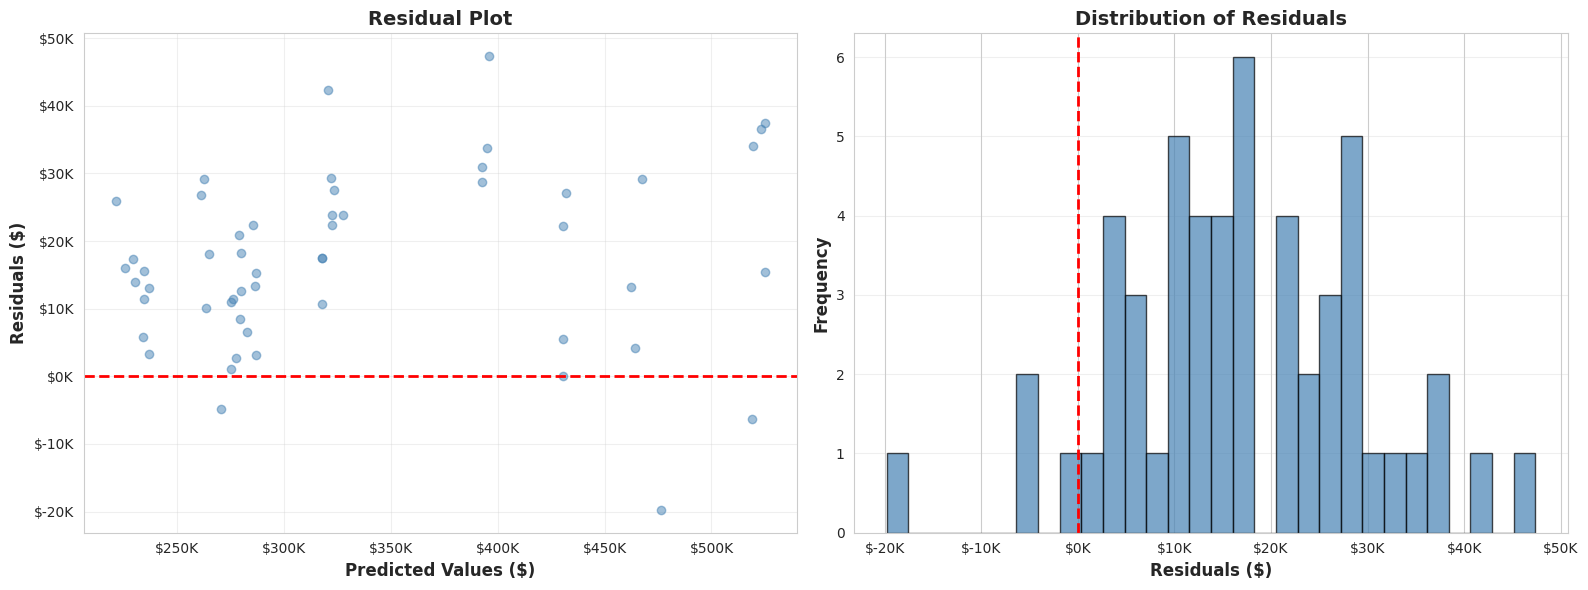

In [32]:
# Residual plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_pred_best, errors, alpha=0.5, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted Values ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Residuals ($)', fontsize=12, fontweight='bold')
ax1.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Histogram of residuals
ax2 = axes[1]
ax2.hist(errors, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Residuals ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()

In [33]:
# Save best model
with open('/content/drive/MyDrive/C++_project/ML/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [34]:
# Save scaler
with open('/content/drive/MyDrive/C++_project/ML/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [35]:
# Save feature names
with open('/content/drive/MyDrive/C++_project/ML/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

In [36]:
with open('/content/drive/MyDrive/C++_project/ML/all_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)

In [37]:
# Save results
results_df.to_csv('/content/drive/MyDrive/C++_project/ML/model_results.csv', index=False)

In [38]:
# Save metadata
metadata = {
    'best_model_name': best_model_name,
    'test_r2': results_df.iloc[0]['Test R²'],
    'test_rmse': results_df.iloc[0]['Test RMSE'],
    'test_mape': results_df.iloc[0]['Test MAPE'],
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(feature_cols),
    'feature_cols': feature_cols,
    'target_mean': float(y.mean()),
    'target_std': float(y.std())
}

with open('/content/drive/MyDrive/C++_project/ML/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)